In [3]:
!pip install torch torchvision matplotlib





[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [6]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Make it binary: "0" vs "not 0"
train_idx = (train_data.targets == 0) | (train_data.targets == 1)
test_idx = (test_data.targets == 0) | (test_data.targets == 1)

train_data.targets = train_data.targets[train_idx]
train_data.data = train_data.data[train_idx]

test_data.targets = test_data.targets[test_idx]
test_data.data = test_data.data[test_idx]

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [8]:
class LogisticRegressionBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 1)  # Output: 1 neuron (binary classification)
        
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten 28x28 image
        return torch.sigmoid(self.linear(x))  # Sigmoid output between 0 and 1

# Create model instance and move to device
model = LogisticRegressionBinary().to(device)

In [9]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [10]:
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 0.0765
Epoch [2/5], Loss: 0.0468
Epoch [3/5], Loss: 0.0314
Epoch [4/5], Loss: 0.0388
Epoch [5/5], Loss: 0.0247


In [11]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 99.91%


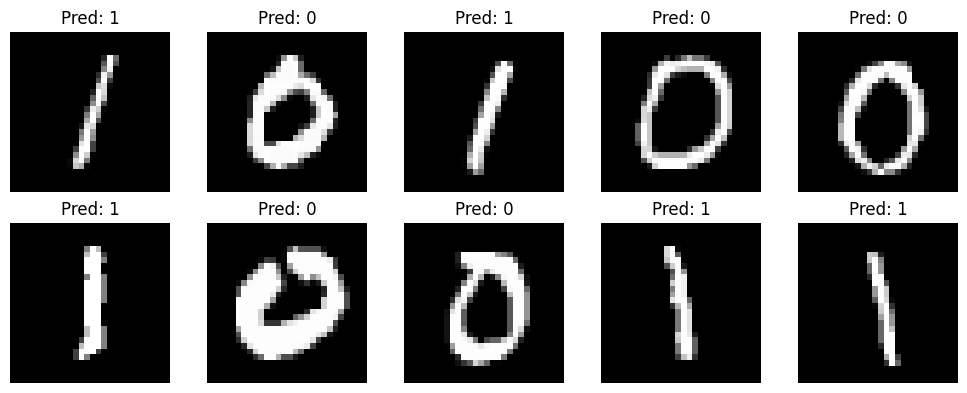

In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    example_outputs = model(example_data.to(device))
    example_preds = (example_outputs >= 0.5).float().cpu()

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(example_data[i][0], cmap='gray')
    ax.set_title(f"Pred: {int(example_preds[i].item())}")
    ax.axis("off")

plt.tight_layout()
plt.show()